# Gradient Descent for Linear Regression

This notebook describes and implements the Gradient Descent algorithm to fit linear regression models. The implemented algorithm is then used to fit linear, polynomial and piecewise polynomial regression models. The three models are then compared using K-fold cross validation. The dataset used in this exercise was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition. The dataset was accessed from UCI Machine Learning repository (Available at: https://archive.ics.uci.edu/ml/datasets/Auto+MPG)

Below is the outline:

* [Data Input](#Data_Input)
* [EDA](#EDA)
* [Linear Regression using Gradient Descent](#Linear_Regression_using_Gradient_Descent)
    * [Linear Regression Cost Function](#Linear_Regression_Cost_Function)
    * [Linear Regression Gradient Algorithm](#Linear_Regression_Gradient_Algorithm)
    * [Gradient Descent Function](#Gradient_Descent_Function)
* [Fitting Linear Regression Parameters](#Fitting_Linear_Regression_Parameters)
    * [Learning Rate Tuning](#Learning_Rate_Tuning)
    * [Parameter Interpretation and Visualization](#Parameter_Interpretation_and_Visualization)
* [Polynomial Regression](#Polynomial_Regression)
* [Model Evaluation: Cross-validation](#Model_Evaluation:_Cross-validation)


In [265]:
# Import libraries
#------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import re
import shlex
from IPython.display import Image
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn' (https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)

# Data Input

In [266]:
# Process input data and create a DF
# text file ->  PD data frame
#-----------------------------------

input_data = []
f = open('auto-mpg.data', 'r')

for line in f:
    line = line.replace("\t"," ")
    line = line.replace("\n"," ")
    input_data.append(shlex.split(line))

# Create a data frame
col_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
auto_mpg = pd.DataFrame(input_data, columns=col_names)

# Convert numeric columns to numeric type
auto_mpg['horsepower'].replace({'?': None},inplace =True)
numeric_cols = auto_mpg.columns[:-1]
auto_mpg[numeric_cols] = auto_mpg[numeric_cols].apply(pd.to_numeric) 


## EDA

We will perform basic EDA. In the end we will select an X and Y variable to test out Gradient Descent and other concepts.

In [267]:
# check the head to understand the data
auto_mpg.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino

In [4]:
auto_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [5]:
auto_mpg.describe().transpose()

count         mean         std     min       25%     50%  \
mpg           398.0    23.514573    7.815984     9.0    17.500    23.0   
cylinders     398.0     5.454774    1.701004     3.0     4.000     4.0   
displacement  398.0   193.425879  104.269838    68.0   104.250   148.5   
horsepower    392.0   104.469388   38.491160    46.0    75.000    93.5   
weight        398.0  2970.424623  846.841774  1613.0  2223.750  2803.5   
acceleration  398.0    15.568090    2.757689     8.0    13.825    15.5   
model_year    398.0    76.010050    3.697627    70.0    73.000    76.0   
origin        398.0     1.572864    0.802055     1.0     1.000     1.0   

                   75%     max  
mpg             29.000    46.6  
cylinders        8.000     8.0  
displacement   262.000   455.0  
horsepower     126.000   230.0  
weight        3608.000  5140.0  
acceleration    17.175    24.8  
model_year      79.000    82.0  
origin           2.000     3.0

Mean MPG is ~23. 

In [6]:
## Use ggplot style
plt.style.use('ggplot')

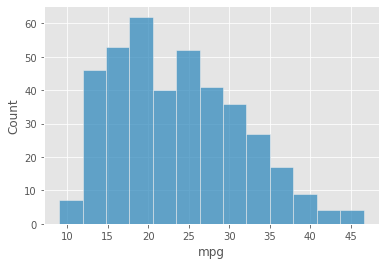

In [7]:
## Distribution of MPGs
sns.histplot(x='mpg', data=auto_mpg)

In [11]:
# Number of unique car types
auto_mpg['car_name'].nunique()

305

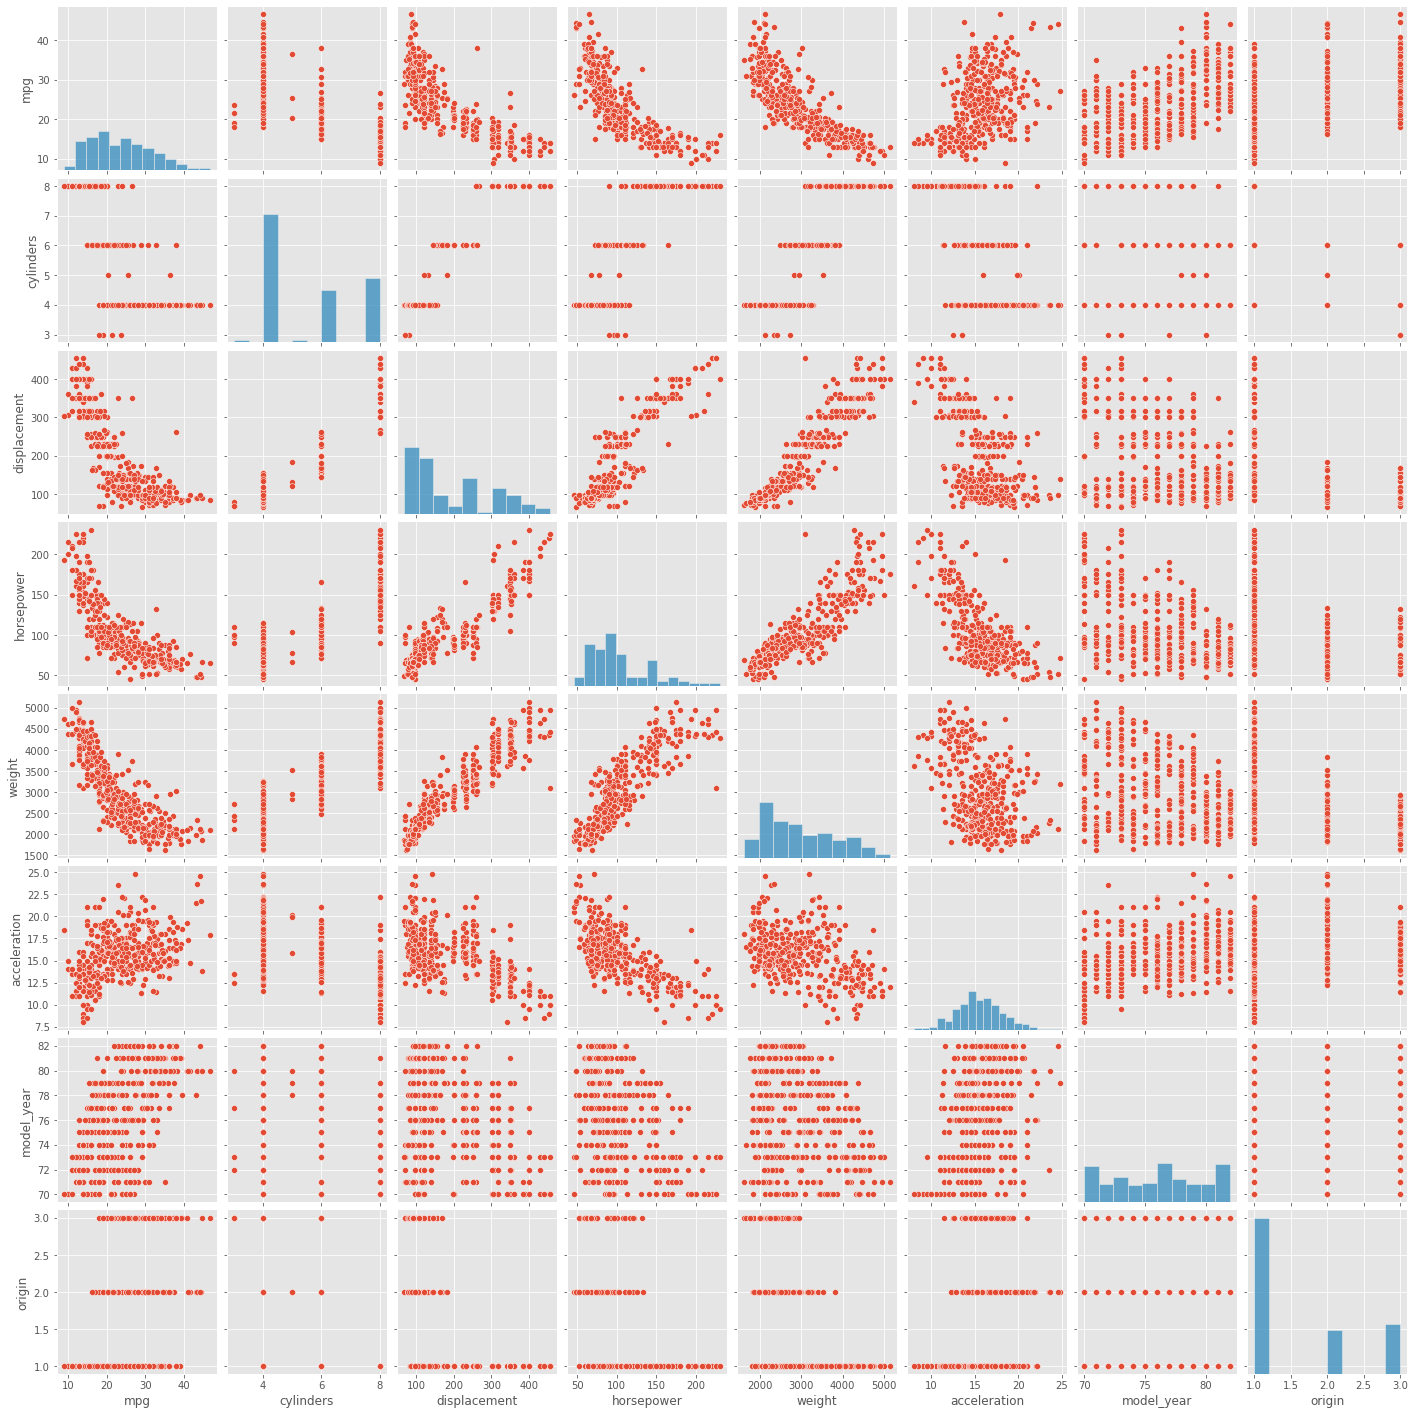

In [12]:
sns.pairplot(auto_mpg, kind='scatter')

In general, fuel economy is inversely proportional to the car's power which is defined by #cylinders, displacement, horsepower, and weight. There is not a very clear relationship with acceleration. From 1970 to 1982, the fuel economy of cars have improved on an average.

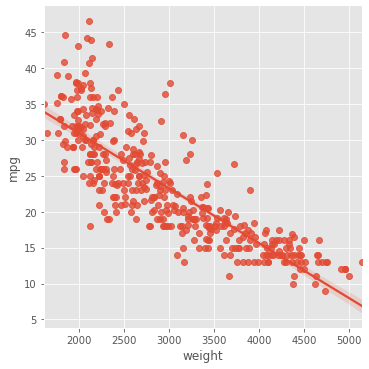

In [268]:
# Lets analyze the relationship between MPG and car's weight
sns.lmplot(x='weight',y='mpg',data=auto_mpg)

The relationship seems linear, however a qudratic or piecewise fit may fit better. Let's use MPG as the *y* and Weight as *X* variables for this exercise. First, let's implement the Gradient Descent algorithm to fit a linear regression model.

## Linear Regression using Gradient Descent 

Gradient descent is an algorithm to find paramter values of a function at the point of global minima. The algorithm starts with an initial guesses of the parameters and keeps improving the parameter values iteratively by moving them in the direction which reduces the function value. The direction which reduces the function value is determined by the gradients of the function. The algorithm stops when the maximum number of iterations are reached or when the cost function stop improving (indicating that the minima has been reached). This function in case of a Machine Learning problem is the cost or loss function.

The gradient descent algorithm requires the following two functions:

* Cost function
* Gradient function

Let's write the cost and gradient function for linear regression and then implement the gradient descent algorithm.

### Linear Regression Cost Function

The linear regression are fit by minimizing the mean squared errors (MSE) defined as:

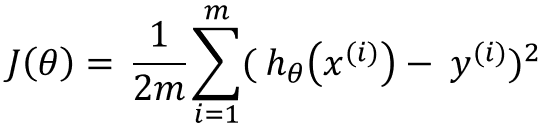

In [9]:
Image("Linreg_cost.png",width=300)

where, *h* is the linear hypothesis and *theta* are the parameters. *y* is the response variable and *x* are the features. For linear regression problems, the MSE is the cost function. Let's write a function to compute MSE.

In [269]:
# Define a function to compute the linear regression cost
def linear_reg_cost(X,y,theta):
    """
    Function to compute linear regression sum of squared error cost
    inputs: X_feaure, y_response, theta for features
    constraints: number of theta must equal the number of feature columns. X and y must have same number of rows
    returns: cost for given value of thetas
    """
    # number of instances
    m = len(y)
    
    # compute hypothesis for given thetas
    h_x = np.matmul(X,theta)
    
    # compute cost
    cost = 1/(2*m) * (((h_x - y) ** 2).sum())
    
    return cost
    

### Linear Regression Gradient Function

The gradients of the MSE function are computed as:

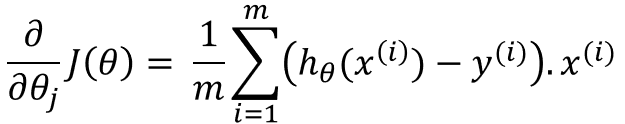

In [12]:
Image("Linreg_grad.png",width=300)

Let's write a function to compute the MSE gradients

In [270]:
# Define a function to compute gradients on linear regression cost function
def linear_reg_grad(X,y,theta):
    """
    Function to compute gradients of SSE cost function. The gradients are computed for a given theta value
    inputs: X_feaure, y_response, theta for features
    constraints: number of theta must equal the number of feature columns. X and y must have same number of rows
    returns: array of gradients for given value of thetas    
    """
    # number of instances
    m = len(y)
    
    # compute hypothesis for given thetas
    h_x = np.matmul(X,theta)
    
    # compute gradients
    grad = (1/m) * (np.matmul(X.transpose(), (h_x - y)))
    
    return grad 
        

### Gradient Descent Algorithm

The gradient descent algorithm starts with an initial value of thetas and keeps updating the thetas until convergence is reached. The algorithm converges when the cost minima is reached or maximum number of iterations have elapsed. The thetas in each iteration are updated as follows:

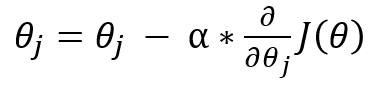

In [15]:
Image("grad_descent.png",width=300)

Let's define the Gradient Descent function that runs a specified number of iterations to update the initial thetas.

In [271]:
# Gradient descent function
def gradient_descent(X, y, initial_theta, cost_func, grad_func, 
                     alpha = 0.01, max_iter = 1000, cost_history = False):
    """
    Gradient descent algorithm to iteratively compute optimal parameters for a cost function
    inputs: X_feaure, y_response, initial thetas. The functions to compute cost and gradients must be passed as well
    alpha: learning rate
    max_iter: maximum iterations
    cost_history: return cost history
    constraints: number of initial_thetas must equal the number of feature columns. X and y must have same number of rows
    returns: array of optimal thetas. Also returns cost history if cost_history is set to true   
    """
    theta = initial_theta.copy()
    if cost_history:
        cost_array = []
        cost_array.append(cost_func(X,y,theta))
        grad_array = []
        grad_array.append(grad_func(X,y,theta))
    
    # start the loop
    for i in range(max_iter):
        # compute gradient
        grad = grad_func(X,y,theta)
        
        # new thetas
        theta = theta - alpha * grad
        
        if cost_history:
            # update cost history
            cost_array.append(cost_func(X,y,theta))
            # update grad history
            grad_array.append(grad_func(X,y,theta))
            
    # number of instances
    if cost_history:
        return theta, cost_array, grad_array
    else:
        return theta

## Fitting Linear Regression Parameters

Let's fit a linear regression model for MPG and vehicle weight using the implemented gradient descent algorithm. 

#### Data prep for Gradient Descent

For this exercise, we are using *mpg* as y and *weight* as X. The mean value of weight is ~2,970 lbs. The gradient descent algorithm is sensitive to the scale of the features and may not be able to converge. Typically, the features are scaled before implementing gradient descent. We will use SciKit Learn's MaxMin scaler for scaling the *weight* field.

In [272]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Generate X and y
data = auto_mpg[['mpg','weight']]
data['weight'] = scaler.fit_transform(np.array(data['weight']).reshape(-1,1))
#data['weight'] = data['weight']/1000
X = np.array(data['weight']).reshape(-1,1)
y = np.array(data['mpg'])
# add a column of ones to X
X = np.column_stack((np.ones(y.shape), X))


As mentioned earlier, the gradient descent algorithm starts with an initial guess of the parameter values. There are two parameters for a simple linear regression - the *slope* coefficient and the *intercept* coefficient. We will randomly generate the initial guesses.

In [273]:
theta_initial = np.random.rand(2)
theta_final, cost_arr, grad_arr = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=True,alpha=0.001, max_iter=1000)

Let's checkout the learned parameters

In [183]:
# Learned parameters
theta_final

array([14.32384999,  3.84972742])

The gradient descent function seem to be working and return a set of coefficients but how can we confirm that the algorithm reached the point of minima. We know that at the point of minima all gradients should be zero or close to zero. Let's check the gradient values for the last iteration.

In [184]:
# Gradients of learned parameters
grad_arr[1000]

array([-7.70909123, -1.18864095])

The gradients are not close to zero. This means that gradient descent did not reach minima in 1000 iterations. More iterations will be needed or the learning rate will need to be adjusted. The learning rate should be selected carefully. A low learning rate requires more iterations to reach the minima. A high learning rate may overshoot the minima and gradient descent may not converge. A learning curve can be plotted to choose the right learning rate and the number of iterations. The learning curve plots the cost at the end of each gradient descent iteration. The leanring rate and number of iterations can be selected using the learning curve. In addition, the gradient should be checked to confirm if convergence was achieved or not. The learning rate tuning is decribed next.

### Learning Rate Tuning

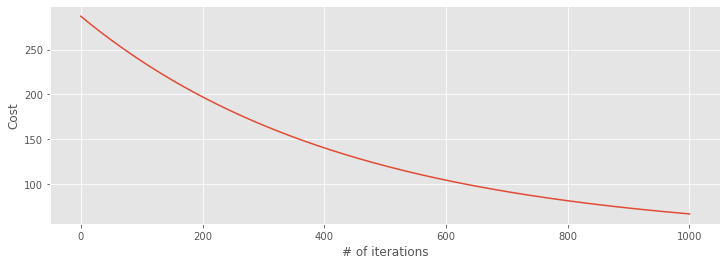

In [274]:
# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
plt.plot(cost_arr)
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

The learning rate for this run was 0.001 with 1K iteration. While the cost function seem to be decreasing at each iteration, the cost curve is not flat, indicating more iterations will be needed. Let's try a run with 2K and 5K iterations.

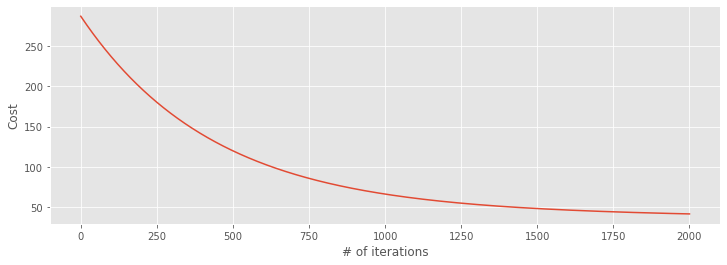

In [275]:
theta_final, cost_arr_001_2K, grad_arr_001_2K = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=True,alpha=0.001, max_iter=2000)

# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
plt.plot(cost_arr_001_2K)
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

2K iterations do flatten the learning curve. Let's check the final gradient values

In [276]:
# Gradients at 2000th iteration
grad_arr_001_2K[2000]

array([-2.81325534,  0.7172892 ])

The gradients are lower but still not close to zero. This indicates that more iterations will be needed to reach minima.

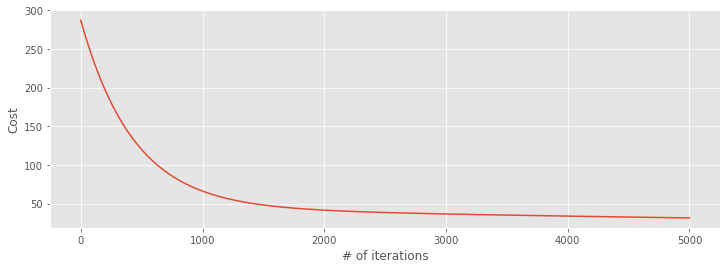

In [277]:
theta_final, cost_arr_001_5K, grad_arr_001_5K = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=True,alpha=0.001, max_iter=5000)

# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
#plt.plot(cost_arr_001_2K)
plt.plot(cost_arr_001_5K)
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

With 5K iterations, the cost curve seem almost flat. Let's check the gradients to confirm convergence

In [278]:
# Gradients at 5000th iteration
grad_arr_001_5K[5000]

array([-0.62391458,  1.34657849])

Even with 5K iterations, the algorithm is not able to reach minima. To speed up training, the learning rate can be increased but this comes at a cost of increased run time. The run time is not a concern for a smaller problem but can be an issue for a model with thousands of features and millions of training instances. Let's try a higher learning rate

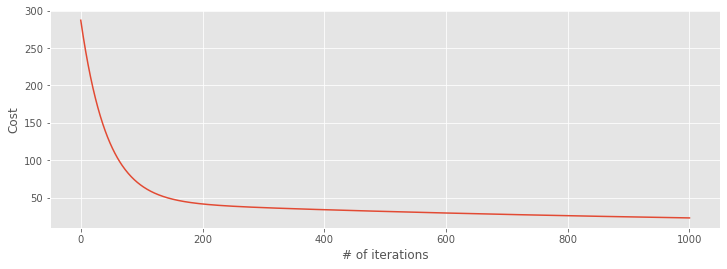

In [279]:
theta_final, cost_arr_01_1K, grad_arr_01_1K = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=True,alpha=0.01, max_iter=1000)

# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
plt.plot(cost_arr_01_1K,label='cost_arr_01_1K')
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

A higher learning rate leads to faster convergence. Let's check the gradients at 1000th iteration.

In [280]:
# Gradients at 5000th iteration
grad_arr_01_1K[1000]

array([-0.43405295,  1.07113122])

Still not close to zero but better than a smaller learning rate with 1000 iterations. The following plot compares the two learning curves

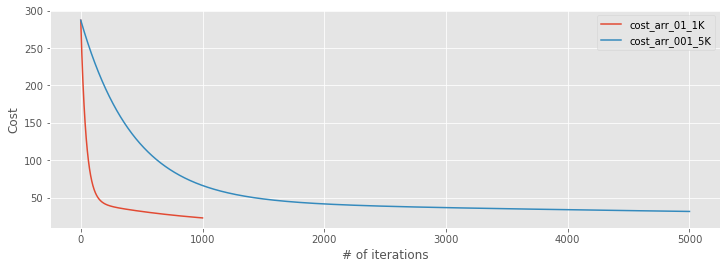

In [281]:
# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
plt.plot(cost_arr_01_1K,label='cost_arr_01_1K')
plt.plot(cost_arr_001_5K,label='cost_arr_001_5K')
plt.legend()
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

Let's run more iterations with the learning rate of 0.05

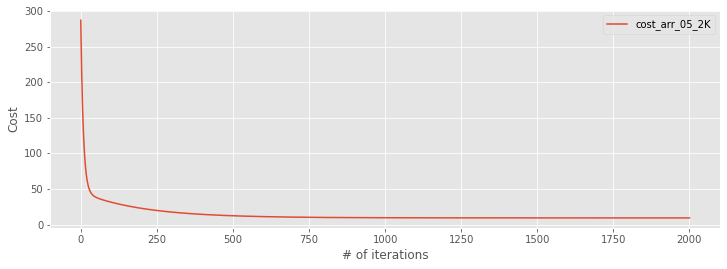

In [282]:
theta_final, cost_arr_05_2K, grad_arr_05_2K = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=True,alpha=0.05, max_iter=2000)

# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
plt.plot(cost_arr_05_2K,label='cost_arr_05_2K')
plt.legend()
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

The cost curve seems very much flat after 1000th iteration. Let's confirm this by looking at the actual cost function value at 1000th, 1500th and 2000th iteration.

In [283]:
print('Cost at 1000th iteration is {} \n'.format(cost_arr_05_2K[1000]))
print('Cost at 1500th iteration is {} \n'.format(cost_arr_05_2K[1500]))
print('Cost at 2000th iteration is {} \n'.format(cost_arr_05_2K[2000]))

Cost at 1000th iteration is 9.639835090605475 

Cost at 1500th iteration is 9.41113278887957 

Cost at 2000th iteration is 9.39218204001407 



Looks like the cost function did not improve much after 1500th iteration. However, to reach absolute global minima, sufficient iterations must be run. Let's check the gradients to confirm convergence.

In [284]:
print('Gradient at 1000th iteration is {} \n'.format(grad_arr_05_2K[1000]))
print('Gradient at 1500th iteration is {} \n'.format(grad_arr_05_2K[1500]))
print('Gradient at 2000th iteration is {} \n'.format(grad_arr_05_2K[2000]))

Gradient at 1000th iteration is [-0.05913114  0.14599704] 

Gradient at 1500th iteration is [-0.01702136  0.04202638] 

Gradient at 2000th iteration is [-0.00489973  0.01209762] 



The gradients are close to zero at the 1500th iteration and very close to zero at the 2000th iteration. Let's run a few more iterations to reach absolute minima. The final run with a learning rate of 0.05 and 2,500 iterations is shown below

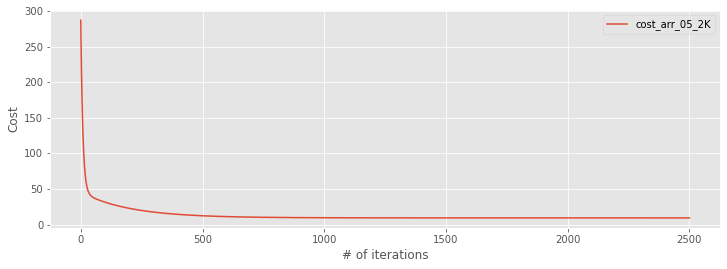

In [285]:
theta_final, cost_arr_05_2K, grad_arr_05_2K = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=True,alpha=0.05, max_iter=2500)

# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
plt.plot(cost_arr_05_2K,label='cost_arr_05_2K')
plt.legend()
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

In [309]:
round(cost_arr_05_2K[2500],2)

9.39

Let's check the gradient at the 2500th iteration

In [197]:
# Gradients at 2500th iteration
print('Gradient at 2000th iteration is {} \n'.format(grad_arr_05_2K[2500]))

Gradient at 2000th iteration is [-0.0013976   0.00345072] 



The gradients are fairly close to zero, so we can conclude that convergence was achieved with a learning rate of 0.05 and 2,500 iterations. Let's interpret and visualize the learned parameters next.

### Parameter Interpretation and Visualization

In [198]:
# The final fitted linear regression parameters
print('The intercept parameter is: {} \n'.format(round(theta_final[0],2)))
print('The slope parameter is: {} \n'.format(round(theta_final[1],2)))

The intercept parameter is: 33.91 

The slope parameter is: -27.01 



Let's see how these parameters compare against those generated using SciKit Learn's linear model package

In [286]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(X[:,1].reshape(-1,1),y)

# The learned parameters
print('The sklearn intercept parameter is: {} \n'.format(round(linReg.intercept_,2)))
print('The sklearn slope parameter is: {} \n'.format(round(linReg.coef_[0],2)))

The sklearn intercept parameter is: 33.93 

The sklearn slope parameter is: -27.08 



The gradient descent coefficient's match SciKit Learn generated coefficients. Let's plot these coefficients and see how the fitted line looks

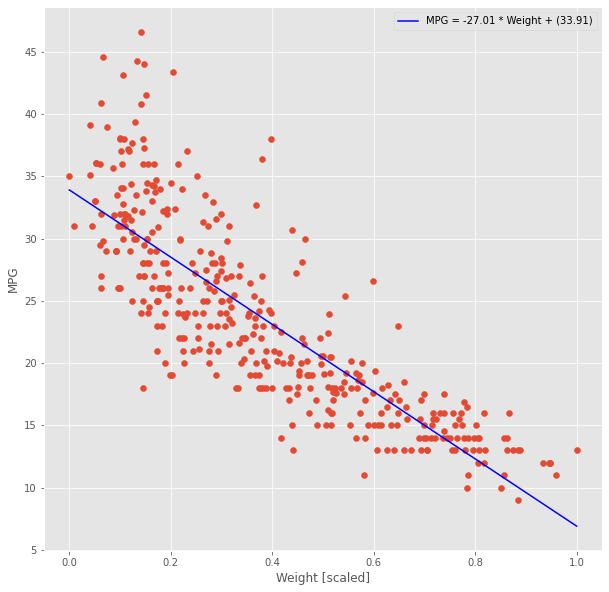

In [287]:
# Final fitted coefficients
c = theta_final[0]
m = theta_final[1]
eqn = 'MPG = {} * Weight + ({})'.format(round(theta_final[1],2),round(theta_final[0],2))

# X-Y scatter plot with fitted line
x_min = min(X[:,1])
x_max = max(X[:,1])
x_plot = np.linspace(x_min, x_max, 100) 
y_plot = m * x_plot + c
plt.figure(figsize=(10,10))
plt.plot(x_plot,y_plot,c='b',label=eqn)
plt.scatter(X[:,1],y)
plt.legend()
plt.xlabel("Weight [scaled]")
plt.ylabel('MPG')
plt.show()

A slope parameter of -27 means that an increase 0.1 units in a vehicle's scaled weight results in a decrease of 2.7 mpg in fuel economy.

The linear model seem to be fitting the data but not perfectly due to noise in the data. In general, the regression models are evaluated by computing mean absolute error (MAE) or mean squared error (MSE). The fit of the linear model is assessed by computing the coefficient of determination (R^2). The R^2 statistic tells us how much of the variance in data is explained by the model. Let's compute th R^2 for this model using sklearn's score method.

In [288]:
print('coefficient of determination: {}'.format(round(linReg.score(X[:,1].reshape(-1,1),y),2)))

coefficient of determination: 0.69


The R^2 value of 0.69 seems a bit low. Generally, a model that fits the data well will have a R^2 value greater than 0.9 but this is dependent on data quality and the underlying relationship in the data. In this case the data is too noisy. The model seem to be underfitting so will have high bias and low variance. A more complex model will be needed to improve th fit on this data. One of the options to increase the flexibility of a linear model is to include polynomial terms. A linear model with higher order features is also called as polynomial regression. Let's repeat the same exercise with polynomial terms.

## Polynomial Regression

In [289]:
# Data prep

data2 = auto_mpg[['mpg','weight']]
data2.loc[:,'weight2'] = data2.loc[:,'weight'] ** 2
data2.loc[:,'weight3'] = data2.loc[:,'weight'] ** 3
data2.loc[:,'weight4'] = data2.loc[:,'weight'] ** 4
data2.loc[:,'weight'] = scaler.fit_transform(np.array(data2.loc[:,'weight']).reshape(-1,1))
data2.loc[:,'weight2'] = scaler.fit_transform(np.array(data2.loc[:,'weight2']).reshape(-1,1))
data2.loc[:,'weight3'] = scaler.fit_transform(np.array(data2.loc[:,'weight3']).reshape(-1,1))
data2.loc[:,'weight4'] = scaler.fit_transform(np.array(data2.loc[:,'weight4']).reshape(-1,1))

data2.head()

mpg    weight   weight2   weight3   weight4
0  18.0  0.536150  0.406261  0.295027  0.208297
1  15.0  0.589736  0.463370  0.350831  0.259297
2  18.0  0.516870  0.386447  0.276361  0.191854
3  16.0  0.516019  0.385582  0.275554  0.191151
4  17.0  0.520556  0.390205  0.279873  0.194923

In [290]:
# Format data for gradient descent
#X = np.array(data2[['weight','weight2']])
X = np.array(data2[['weight','weight2','weight3']])
y = np.array(data2['mpg'])
# add a column of ones to X
X = np.column_stack((np.ones(y.shape), X))

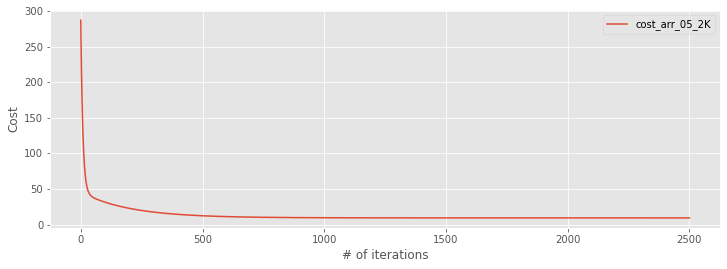

In [291]:
theta_initial = np.random.rand(4)
theta_final, cost_arr_poly_05_2K, grad_arr_poly_05_2K = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=True,alpha=0.05, max_iter=2500)
# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
#plt.plot(cost_arr_poly_05_2K,label='cost_arr_poly_05_2K')
plt.plot(cost_arr_05_2K,label='cost_arr_05_2K')
plt.legend()
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

In [308]:
# cost at 2500th iteration
round(cost_arr_poly_05_2K[2500],2)

10.11

Overall, the cost is slightly higher than the linear model. Let's check the gradients at 2500th iteration

In [293]:
# Gradients at 2500th iteration
print('Gradient at 2000th iteration is {} \n'.format(grad_arr_05_2K[2500]))

Gradient at 2000th iteration is [-0.00141043  0.00348239] 



The gradients seem fairly close to zero. Let's plot the fitted equation.

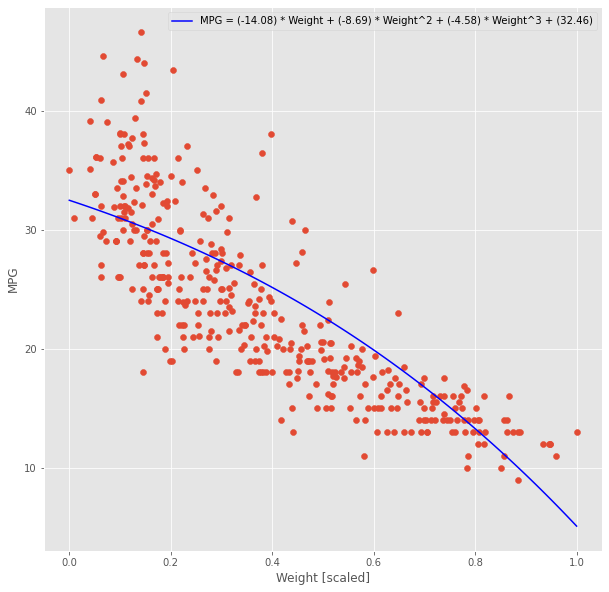

In [294]:
# Plot polynomial regression equation

# Final fitted coefficients
c = theta_final[0]
m1 = theta_final[1]
m2 = theta_final[2]
m3 = theta_final[3]
eqn = 'MPG = ({}) * Weight + ({}) * Weight^2 + ({}) * Weight^3 + ({})'.format(round(theta_final[1],2),
                                                                             round(theta_final[2],2),
                                                                            round(theta_final[3],2),
                                                                           round(theta_final[0],2))

# X-Y scatter plot with fitted line
x_min = min(X[:,1])
x_max = max(X[:,1])
x_plot = np.linspace(x_min, x_max, 100) 
#y_plot = m1 * x_plot + m2 * (x_plot ** 2) + c
y_plot = m1 * x_plot + m2 * (x_plot ** 2) + m3 * (x_plot ** 3) + c
plt.figure(figsize=(10,10))
plt.plot(x_plot,y_plot,c='b',label=eqn)
plt.scatter(X[:,1],y)
plt.legend()
plt.xlabel("Weight [scaled]")
plt.ylabel('MPG')
plt.show()

From just the plot, it is very hard to say if this model fits the data better than a linear model. Let's compute the coefficient of determination.

In [295]:

linReg.fit(X[:,1:3],y)

print('coefficient of determination: {}'.format(round(linReg.score(X[:,1:3],y),2)))

coefficient of determination: 0.71


The polynomial regression has a slightly better R^2 than the linear model. The R^2 comparison is not very accurate in this case since the two models had different number of features. The polynomial regression had slightly worse training error compared to the linear model. In practice, teh models are evaluated by computing the MAE or MSE metric on the test data. We do not have a test dataset. The K-fold cross-validation method can be used to compare the linear and polynomial regression. Before, we perform cross-validation, let's try another specification called piecewise polynomial regression.

## Piecewise Polynomial Regression

A visual inspection of the scatter plot reveals that a piecewise polynomial regression model might fit the data better. A simple piecewise linear regression is represented as:

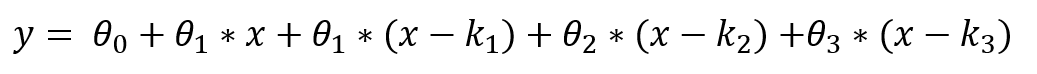

In [123]:
Image("piecewise_lr.png",width=600)

where, thetas are the regression parameters and *Ks* are the knots for piecewise regression.

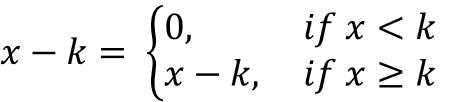

In [122]:
Image("piecewise_lr_variable.png",width=300)

This can be easily extended to piecewise polynomial regression. Let's prepare the data with the following knots: 0.2, 0.4, and 0.6

In [296]:
# Data prep

data2 = auto_mpg[['mpg','weight']]
data2.loc[:,'weight2'] = data2.loc[:,'weight'] ** 2
data2.loc[:,'weight3'] = data2.loc[:,'weight'] ** 3
data2.loc[:,'weight4'] = data2.loc[:,'weight'] ** 4
data2.loc[:,'weight'] = scaler.fit_transform(np.array(data2.loc[:,'weight']).reshape(-1,1))
data2.loc[:,'weight2'] = scaler.fit_transform(np.array(data2.loc[:,'weight2']).reshape(-1,1))
data2.loc[:,'weight3'] = scaler.fit_transform(np.array(data2.loc[:,'weight3']).reshape(-1,1))
data2.loc[:,'weight4'] = scaler.fit_transform(np.array(data2.loc[:,'weight4']).reshape(-1,1))

# prepare data for piecewise poly regression
k1 = 0.2
k2 = 0.35
k3 = 0.65

data2.loc[:,'x'] = data2.loc[:,'weight']
data2.loc[:,'x_k1'] = np.where(data2.loc[:,'x'] >= k1, data2.loc[:,'x'] - k1, 0)
data2.loc[:,'x_k2'] = np.where(data2.loc[:,'x'] >= k2, data2.loc[:,'x'] - k2, 0)
data2.loc[:,'x_k3'] = np.where(data2.loc[:,'x'] >= k3, data2.loc[:,'x'] - k3, 0)

data2.loc[:,'x2'] = data2.loc[:,'weight2']
data2.loc[:,'x2_k1'] = np.where(data2.loc[:,'x2'] >= k1, data2.loc[:,'x2'] - k1, 0)
data2.loc[:,'x2_k2'] = np.where(data2.loc[:,'x2'] >= k2, data2.loc[:,'x2'] - k2, 0)
data2.loc[:,'x2_k3'] = np.where(data2.loc[:,'x2'] >= k3, data2.loc[:,'x2'] - k3, 0)

data2.loc[:,'x3'] = data2.loc[:,'weight3']
data2.loc[:,'x3_k1'] = np.where(data2.loc[:,'x3'] >= k1, data2.loc[:,'x3'] - k1, 0)
data2.loc[:,'x3_k2'] = np.where(data2.loc[:,'x3'] >= k2, data2.loc[:,'x3'] - k2, 0)
data2.loc[:,'x3_k3'] = np.where(data2.loc[:,'x3'] >= k3, data2.loc[:,'x3'] - k3, 0)

data2.loc[:,'x4'] = data2.loc[:,'weight4']
data2.loc[:,'x4_k1'] = np.where(data2.loc[:,'x4'] >= k1, data2.loc[:,'x4'] - k1, 0)
data2.loc[:,'x4_k2'] = np.where(data2.loc[:,'x4'] >= k2, data2.loc[:,'x4'] - k2, 0)
data2.loc[:,'x4_k3'] = np.where(data2.loc[:,'x4'] >= k3, data2.loc[:,'x4'] - k3, 0)


data2.head()

mpg    weight   weight2   weight3   weight4         x      x_k1      x_k2  \
0  18.0  0.536150  0.406261  0.295027  0.208297  0.536150  0.336150  0.186150   
1  15.0  0.589736  0.463370  0.350831  0.259297  0.589736  0.389736  0.239736   
2  18.0  0.516870  0.386447  0.276361  0.191854  0.516870  0.316870  0.166870   
3  16.0  0.516019  0.385582  0.275554  0.191151  0.516019  0.316019  0.166019   
4  17.0  0.520556  0.390205  0.279873  0.194923  0.520556  0.320556  0.170556   

   x_k3        x2  ...     x2_k2  x2_k3        x3     x3_k1     x3_k2  x3_k3  \
0   0.0  0.406261  ...  0.056261    0.0  0.295027  0.095027  0.000000    0.0   
1   0.0  0.463370  ...  0.113370    0.0  0.350831  0.150831  0.000831    0.0   
2   0.0  0.386447  ...  0.036447    0.0  0.276361  0.076361  0.000000    0.0   
3   0.0  0.385582  ...  0.035582    0.0  0.275554  0.075554  0.000000    0.0   
4   0.0  0.390205  ...  0.040205    0.0  0.279873  0.079873  0.000000    0.0   

         x4     x4_k1  x4_k2  x4_k3  
0  0.208297  0.008297    0.0    0.0  
1  0.259297  0.059297    0.0    0.0  
2  0.191854  0.000000    0.0    0.0  
3  0.191151  0.000000    0.0    0.0  
4  0.194923  0.000000    0.0    0.0  

[5 rows x 21 columns]

In [297]:
# Format data for gradient descent
#X = np.array(data2[['weight','weight2']])
X = np.array(data2[['x','x2','x3','x_k1','x2_k1','x3_k1','x_k2','x2_k2','x3_k2','x_k3','x2_k3','x3_k3']])
y = np.array(data2['mpg'])
# add a column of ones to X
X = np.column_stack((np.ones(y.shape), X))

The piecewise regression with degree=3 terms will have 13 regression parameters. Lets fit this model using the gradient descent function.

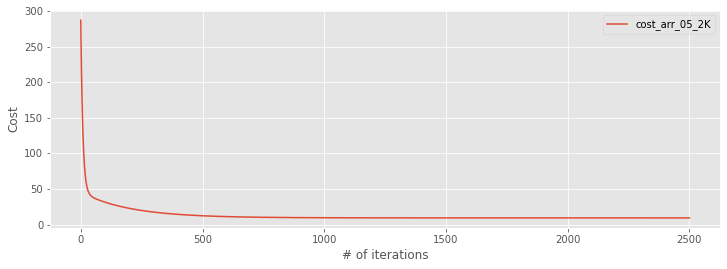

In [298]:
theta_initial = np.random.rand(13)
theta_step, cost_arr_step_05_5K, grad_arr_step_05_5K = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=True,alpha=0.05, max_iter=5000)
# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
#plt.plot(cost_arr_poly_05_2K,label='cost_arr_poly_05_2K')
plt.plot(cost_arr_05_2K,label='cost_arr_05_2K')
plt.legend()
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()

In [299]:
theta_step

array([ 33.78262214, -15.71588073,  -9.7522322 ,  -4.98270845,
        -9.32498713,   0.79837971,   5.7054454 ,   1.35151931,
         5.65645106,   6.36214767,   3.59871685,   2.53357051,
         1.91604539])

In [307]:
round(cost_arr_step_05_5K[5000],2)

8.92

In [301]:
grad_arr_step_05_5K[5000]

array([-0.00519071,  0.01803917,  0.00852886,  0.00263542, -0.00425308,
       -0.01091975, -0.00778995, -0.01234858, -0.0062366 ,  0.00091343,
        0.00189536,  0.00417284,  0.0036479 ])

The gradients are close to zero for all parameters. The training error is lower than both linear and the polynomial model. This model seem to be fitting the data better. Let's plot the fitted model.

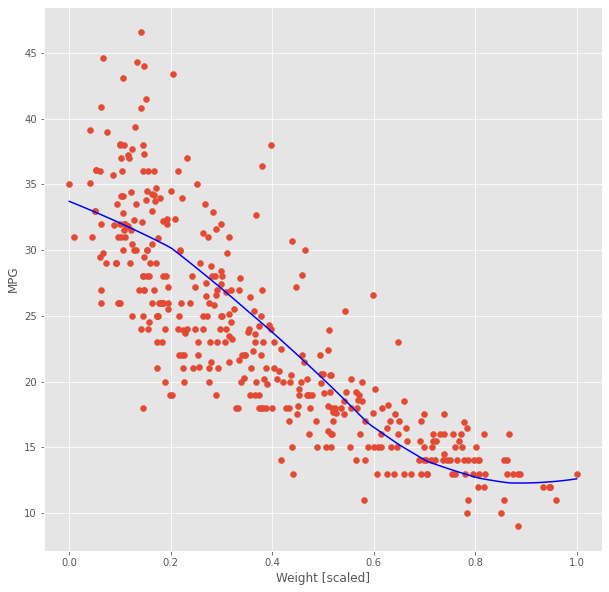

In [253]:
# Plot piecewise polynomial regression equation

# Final fitted coefficients
c = theta_step[0]
m1 = theta_step[1]
m2 = theta_step[2]
m3 = theta_step[3]
m1_k1 = theta_step[4]
m2_k1 = theta_step[5]
m3_k1 = theta_step[6]
m1_k2 = theta_step[7]
m2_k2 = theta_step[8]
m3_k2 = theta_step[9]
m1_k3 = theta_step[10]
m2_k3 = theta_step[11]
m3_k3 = theta_step[12]

k1 = 0.2
k2 = 0.35
k3 = 0.65

# X-Y scatter plot with fitted line
x_min = min(X[:,1])
x_max = max(X[:,1])
x_plot = np.linspace(x_min, x_max, 100)
x_plot2 = x_plot ** 2
x_plot3 = x_plot ** 3

x_plot_k1 = np.where(x_plot>=k1,x_plot-k1,0)
x_plot2_k1 = np.where(x_plot2>=k1,x_plot2-k1,0)
x_plot3_k1 = np.where(x_plot3>=k1,x_plot3-k1,0)

x_plot_k2 = np.where(x_plot>=k2,x_plot-k2,0)
x_plot2_k2 = np.where(x_plot2>=k2,x_plot2-k2,0)
x_plot3_k2 = np.where(x_plot3>=k2,x_plot3-k2,0)

x_plot_k3 = np.where(x_plot>=k3,x_plot-k3,0)
x_plot2_k3 = np.where(x_plot2>=k3,x_plot2-k3,0)
x_plot3_k3 = np.where(x_plot3>=k3,x_plot3-k3,0)

y_plot = m1 * x_plot + m2 * x_plot2 + m3 * x_plot3 + c + \
         m1_k1 * x_plot_k1 + m2_k1 * x_plot2_k1 + m3_k1 * x_plot3_k1 + \
         m1_k2 * x_plot_k2 + m2_k2 * x_plot2_k2 + m3_k2 * x_plot3_k2 + \
         m1_k3 * x_plot_k3 + m2_k3 * x_plot2_k3 + m3_k3 * x_plot3_k3



plt.figure(figsize=(10,10))
plt.plot(x_plot,y_plot,c='b')
plt.scatter(X[:,1],y)
#plt.legend()
plt.xlabel("Weight [scaled]")
plt.ylabel('MPG')
plt.show()

In [302]:
linReg1 = LinearRegression()
linReg1.fit(X[:,1:12],y)

print('coefficient of determination: {}'.format(round(linReg1.score(X[:,1:12],y),2)))

coefficient of determination: 0.72


Among the three models (linear, polynomial, and piecewise polynomial), the piecewise polynomial model has the least traning error. However, having a lower training does not guarantee a better generalization on test data. The models that overfit the training data have lower training error but high test error due to high vaariance. At the model selection stage, models are compared on their performance on the validation data. Typically, cross-validation is performed to evaluate model performance. Let's crossvalidate the three models to see which one performs better. 

## Model Evaluation: Cross-validation

In this section we will compare linear model against the polynomial model. We will use the K-fold cross-validation technique to compare the performance of the three models. K-fold crossvalidation involves splitting the training dataset into K folds. The model is trained using K-1 folds and test metric is estimated on the left out fold. This is repeated with each fold as the test set. The test metrics across all the folds are averaged to estimate the crossvalidation metric. We will use K=5 for this exercise 

In [303]:
from sklearn.metrics import mean_squared_error

In [304]:
# generic predict function for a linear model
def predict_lin_model(X,theta):
    """
    Function to predict linear regression labels using dependent features (X) and fit parameters (theta)
    X: input features stacked column wise. Include a column of one for intercept
    theta: parameters in same order as the features
    """
    y_pred = np.matmul(X,theta)
    return y_pred

In [305]:
# Get K-folds
from sklearn.model_selection import KFold
kfold = KFold(5, shuffle=True, random_state=1)

In [306]:
# cross-validation metrics
lin_cv_scores = []
pol_cv_scores = []
stp_cv_scores = []

data_cv = auto_mpg[['mpg','weight']]

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()

# knots for piecewise regression
k1 = 0.2
k2 = 0.35
k3 = 0.65

# K-fold iterations
for train, test in kfold.split(data_cv):
    
    # get train and test splits
    train_set = data_cv.loc[train] 
    test_set = data_cv.loc[test]
    
    # train data prep
    train_set.loc[:,'weight2'] = train_set.loc[:,'weight'] ** 2
    train_set.loc[:,'weight3'] = train_set.loc[:,'weight'] ** 3
    
    scaler1.fit(np.array(train_set.loc[:,'weight']).reshape(-1,1))
    scaler2.fit(np.array(train_set.loc[:,'weight2']).reshape(-1,1))
    scaler3.fit(np.array(train_set.loc[:,'weight3']).reshape(-1,1))
    
    train_set.loc[:,'weight'] = scaler1.transform(np.array(train_set.loc[:,'weight']).reshape(-1,1))
    train_set.loc[:,'weight2'] = scaler2.transform(np.array(train_set.loc[:,'weight2']).reshape(-1,1))
    train_set.loc[:,'weight3'] = scaler3.transform(np.array(train_set.loc[:,'weight3']).reshape(-1,1))
    
    train_set.loc[:,'x'] = train_set.loc[:,'weight']
    train_set.loc[:,'x_k1'] = np.where(train_set.loc[:,'x'] >= k1, train_set.loc[:,'x'] - k1, 0)
    train_set.loc[:,'x_k2'] = np.where(train_set.loc[:,'x'] >= k2, train_set.loc[:,'x'] - k2, 0)
    train_set.loc[:,'x_k3'] = np.where(train_set.loc[:,'x'] >= k3, train_set.loc[:,'x'] - k3, 0)

    train_set.loc[:,'x2'] = train_set.loc[:,'weight2']
    train_set.loc[:,'x2_k1'] = np.where(train_set.loc[:,'x2'] >= k1, train_set.loc[:,'x2'] - k1, 0)
    train_set.loc[:,'x2_k2'] = np.where(train_set.loc[:,'x2'] >= k2, train_set.loc[:,'x2'] - k2, 0)
    train_set.loc[:,'x2_k3'] = np.where(train_set.loc[:,'x2'] >= k3, train_set.loc[:,'x2'] - k3, 0)

    train_set.loc[:,'x3'] = train_set.loc[:,'weight3']
    train_set.loc[:,'x3_k1'] = np.where(train_set.loc[:,'x3'] >= k1, train_set.loc[:,'x3'] - k1, 0)
    train_set.loc[:,'x3_k2'] = np.where(train_set.loc[:,'x3'] >= k2, train_set.loc[:,'x3'] - k2, 0)
    train_set.loc[:,'x3_k3'] = np.where(train_set.loc[:,'x3'] >= k3, train_set.loc[:,'x3'] - k3, 0)
    
    X_train = np.array(train_set[['x','x2','x3','x_k1','x2_k1','x3_k1','x_k2','x2_k2','x3_k2','x_k3','x2_k3','x3_k3']])
    y_train = np.array(train_set['mpg'])
    X_train = np.column_stack((np.ones(y_train.shape), X_train))
    
    # transform test data using train scaler
    test_set.loc[:,'weight2'] = test_set.loc[:,'weight'] ** 2
    test_set.loc[:,'weight3'] = test_set.loc[:,'weight'] ** 3
    
    test_set.loc[:,'weight'] = scaler1.transform(np.array(test_set.loc[:,'weight']).reshape(-1,1))
    test_set.loc[:,'weight2'] = scaler2.transform(np.array(test_set.loc[:,'weight2']).reshape(-1,1))
    test_set.loc[:,'weight3'] = scaler3.transform(np.array(test_set.loc[:,'weight3']).reshape(-1,1))
    
    test_set.loc[:,'x'] = test_set.loc[:,'weight']
    test_set.loc[:,'x_k1'] = np.where(test_set.loc[:,'x'] >= k1, test_set.loc[:,'x'] - k1, 0)
    test_set.loc[:,'x_k2'] = np.where(test_set.loc[:,'x'] >= k2, test_set.loc[:,'x'] - k2, 0)
    test_set.loc[:,'x_k3'] = np.where(test_set.loc[:,'x'] >= k3, test_set.loc[:,'x'] - k3, 0)

    test_set.loc[:,'x2'] = test_set.loc[:,'weight2']
    test_set.loc[:,'x2_k1'] = np.where(test_set.loc[:,'x2'] >= k1, test_set.loc[:,'x2'] - k1, 0)
    test_set.loc[:,'x2_k2'] = np.where(test_set.loc[:,'x2'] >= k2, test_set.loc[:,'x2'] - k2, 0)
    test_set.loc[:,'x2_k3'] = np.where(test_set.loc[:,'x2'] >= k3, test_set.loc[:,'x2'] - k3, 0)

    test_set.loc[:,'x3'] = test_set.loc[:,'weight3']
    test_set.loc[:,'x3_k1'] = np.where(test_set.loc[:,'x3'] >= k1, test_set.loc[:,'x3'] - k1, 0)
    test_set.loc[:,'x3_k2'] = np.where(test_set.loc[:,'x3'] >= k2, test_set.loc[:,'x3'] - k2, 0)
    test_set.loc[:,'x3_k3'] = np.where(test_set.loc[:,'x3'] >= k3, test_set.loc[:,'x3'] - k3, 0)

    
    X_test = np.array(test_set[['x','x2','x3','x_k1','x2_k1','x3_k1','x_k2','x2_k2','x3_k2','x_k3','x2_k3','x3_k3']])
    y_test = np.array(test_set['mpg'])
    X_test = np.column_stack((np.ones(y_test.shape), X_test))
    
    # train linear model
    theta_initial = np.random.rand(2)
    theta_final_lin = gradient_descent(X_train[:,0:2],y_train,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=False,alpha=0.05, max_iter=2500)
    
    # train poly model
    theta_initial = np.random.rand(4)
    theta_final_pol = gradient_descent(X_train[:,0:4],y_train,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=False,alpha=0.05, max_iter=2500)
    
    # train piecewise poly model
    theta_initial = np.random.rand(13)
    theta_final_stp = gradient_descent(X_train,y_train,theta_initial,linear_reg_cost,linear_reg_grad, 
                                         cost_history=False,alpha=0.05, max_iter=2500)
    
    # predict using trained models on test set
    predict_lin = predict_lin_model(X_test[:,0:2],theta_final_lin)
    predict_pol = predict_lin_model(X_test[:,0:4],theta_final_pol)
    predict_stp = predict_lin_model(X_test,theta_final_stp)
    
    # compute evaluation metrics for both models
    lin_mse = mean_squared_error(y_test, predict_lin)
    pol_mse = mean_squared_error(y_test, predict_pol)
    stp_mse = mean_squared_error(y_test, predict_stp)
    
    # update metric arrays
    lin_cv_scores.append(lin_mse)
    pol_cv_scores.append(pol_mse)
    stp_cv_scores.append(stp_mse)
    
# compute mean scores
print('Mean CV score for linear regression: {}\n'.format(round(sum(lin_cv_scores)/len(lin_cv_scores),2)))
print('Mean CV score for polynomial regression: {}\n'.format(round(sum(pol_cv_scores)/len(pol_cv_scores),2)))
print('Mean CV score for piecewise polynomial regression: {}\n'.format(round(sum(stp_cv_scores)/len(stp_cv_scores),2)))
    

Mean CV score for linear regression: 18.87

Mean CV score for polynomial regression: 20.3

Mean CV score for piecewise polynomial regression: 18.53



The piecewise polynomial regression had the lowest training error and cross validation error. The polynomial regression performed worse on both training and test errors. Even though polynomial regression was more complex than linear, it introduced a higher bias. In this example, the piecewise polynomial regression is the best model. A more complex model can be used to further improve the performance. It should be noted that a complex model may not generalize well as it may overfit the training data. 

Overfitting can be controlled by regularizing the fitting parameters. Regularization introduces additional constraints on fitting parameters. As a result the complexity of the model reduces. The less complex a model, the less likely it is to overfit the training data. Let's write a gradient descent function to fit linear model with regularization

## Regularization

In this example we will implement Ridge regularization which is based on L2 norm. The linear regression cost function with regularization terms is written as:

### Regularized Linear Regression Cost Function

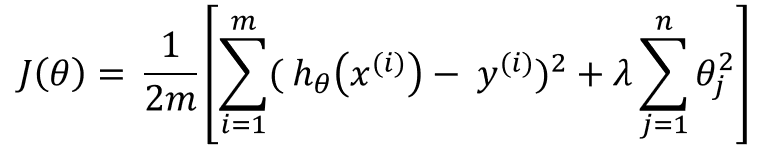

In [40]:
Image("Linreg_cost_regularization.png",width=300)

where, lambda is the regularization parameter and thetas are fit parameters. As a general convention, the intercept parameter is not regularized. Let's define the function for computing linear regression cost with regularization

In [310]:
# Regularized Linear regression cost
def re_linear_reg_cost(X,y,theta,lmbda = 0):
    """
    Function to compute linear regression sum of squared error cost
    inputs: X_feaure, y_response, theta for features
    lmbda: regularization parameter
    assumes the first element in theta is the intercept which is not regularized
    constraints: number of theta must equal the number of feature columns. X and y must have same number of rows
    returns: cost for given value of thetas
    """
    # number of instances
    m = len(y)
    
    # compute hypothesis for given thetas
    h_x = np.matmul(X,theta)
    
    # compute cost
    cost = 1/(2*m) * (((h_x - y) ** 2).sum() + lmbda * (theta[1:] ** 2).sum())
    
    return cost
    

### Regularized Linear Regression Gradient Function

The linear regression gradient function with a regularization term is derived as:

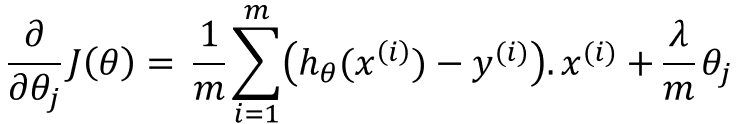

In [311]:
Image("Linreg_grad_regularization.png",width=300)

The function to return gradients of regularized linear regression cost function is defined as:

In [312]:
# Define a function to compute gradients on linear regression cost function
def re_linear_reg_grad(X,y,theta,lmbda=0):
    """
    Function to compute gradients of SSE cost function. The gradients are computed for a given theta value
    inputs: X_feaure, y_response, theta for features
    constraints: number of theta must equal the number of feature columns. X and y must have same number of rows
    assumes the first element of theta is the intercept which is not regularized
    returns: array of gradients for given value of thetas    
    """
    # set intercept to zero for grado computation
    theta_reg = theta.copy()
    theta_reg[0] = 0
    # number of instances
    m = len(y)
    
    # compute hypothesis for given thetas
    h_x = np.matmul(X,theta)
    
    # compute gradients
    grad = (1/m) * (np.matmul(X.transpose(), (h_x - y))) + (lmbda/m) * theta_reg
    
    return grad 

### Gradient Descent Algorithm

The gradient descent algorithm works the same as before. The gradients and cost are computed using the regularization parameter.

In [328]:
# Gradient descent function
def re_gradient_descent(X, y, initial_theta, cost_func, grad_func, lmbda=0,
                     alpha = 0.01, max_iter = 1000, cost_history = False):
    """
    Gradient descent algorithm to iteratively compute optimal parameters for a cost function
    inputs: X_feaure, y_response, initial thetas. The functions to compute cost and gradients must be passed as well
    alpha: learning rate
    max_iter: maximum iterations
    cost_history: return cost history
    constraints: number of initial_thetas must equal the number of feature columns. X and y must have same number of rows
    returns: array of optimal thetas. Also returns cost history if cost_history is set to true   
    """
    theta = initial_theta.copy()
    if cost_history:
        cost_array = []
        cost_array.append(cost_func(X,y,theta,lmbda))
        grad_array = []
        grad_array.append(grad_func(X,y,theta,lmbda))
    
    # start the loop
    for i in range(max_iter):
        # compute gradient
        grad = grad_func(X,y,theta,lmbda)
        
        # new thetas
        theta = theta - alpha * grad
        
        if cost_history:
            # update cost history
            cost_array.append(cost_func(X,y,theta,lmbda))
            # update grad history
            grad_array.append(grad_func(X,y,theta,lmbda))
    
    # number of instances
    if cost_history:
        return theta, cost_array, grad_array
    else:
        return theta

Let's refit the polynomial regression with regularization. First, let's test the function with lambda = 0, which sohuld return the same coefficients as the old function.

In [315]:
# Format data for gradient descent
#X = np.array(data2[['weight','weight2']])
X = np.array(data2[['weight','weight2','weight3']])
y = np.array(data2['mpg'])
# add a column of ones to X
X = np.column_stack((np.ones(y.shape), X))

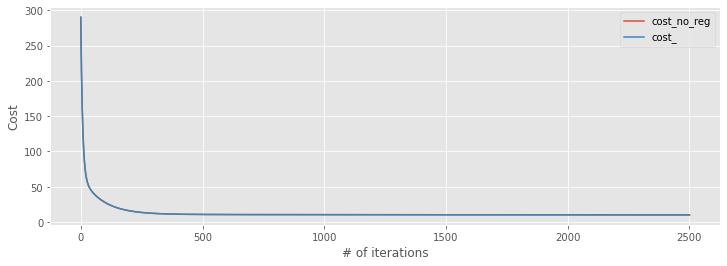

In [332]:
theta_initial = np.random.rand(4)
theta_no_reg, cost_no_reg, grad_no_reg = re_gradient_descent(X,y,theta_initial,re_linear_reg_cost,re_linear_reg_grad, 
                                                             lmbda=0, 
                                                             cost_history=True,alpha=0.05, max_iter=2500)

theta_, cost_, grad_ = gradient_descent(X,y,theta_initial,linear_reg_cost,linear_reg_grad,
                                         cost_history=True,alpha=0.05, max_iter=2500)

# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
plt.plot(cost_no_reg,label='cost_no_reg')
plt.plot(cost_,label='cost_')
plt.legend()
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()


The learning curves cannot be distinguised between the two functions. Let's compare the parameter values

In [333]:
print('Polynomial regression coefficients with lambda = 0: ', theta_no_reg)
print('Polynomial regression coefficients old function   : ', theta_)

Polynomial regression coefficients with lambda = 0:  [ 32.44419796 -13.61605893  -9.57742043  -4.15264222]
Polynomial regression coefficients old function   :  [ 32.44419796 -13.61605893  -9.57742043  -4.15264222]


Let's try a few regularization parameters to understand how it affects the model parameters. In general, the regularization paramter pushes the coefficients towards lower values. This makes the the model fit more smoother and avoids overfitting. However, a very high regularization paramter may push the coefficients to zero leading to a high bias situation. The regularization parameter can also be chosen based on crossvalidation metric. For this exercise, let's try the following regularization parameters: [0,0.3,10,100,1000]

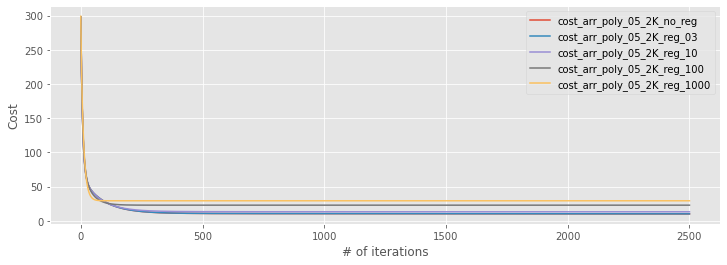

In [334]:
theta_initial = np.random.rand(4)
theta_no_reg, cost_arr_poly_05_2K_no_reg, grad_arr_poly_05_2K_no_reg = \
re_gradient_descent(X,y,theta_initial,re_linear_reg_cost,re_linear_reg_grad, lmbda=0,
                    cost_history=True,alpha=0.05, max_iter=2500)

theta_reg_03, cost_arr_poly_05_2K_reg_03, grad_arr_poly_05_2K_reg_03 = \
re_gradient_descent(X,y,theta_initial,re_linear_reg_cost,re_linear_reg_grad, lmbda=0.3,
                    cost_history=True,alpha=0.05, max_iter=2500)

theta_reg_10, cost_arr_poly_05_2K_reg_10, grad_arr_poly_05_2K_reg_10 = \
re_gradient_descent(X,y,theta_initial,re_linear_reg_cost,re_linear_reg_grad, lmbda=10,
                    cost_history=True,alpha=0.05, max_iter=2500)

theta_reg_100, cost_arr_poly_05_2K_reg_100, grad_arr_poly_05_2K_reg_100 = \
re_gradient_descent(X,y,theta_initial,re_linear_reg_cost,re_linear_reg_grad, lmbda=100,
                    cost_history=True,alpha=0.05, max_iter=2500)

theta_reg_1000, cost_arr_poly_05_2K_reg_1000, grad_arr_poly_05_2K_reg_1000 = \
re_gradient_descent(X,y,theta_initial,re_linear_reg_cost,re_linear_reg_grad, lmbda=1000,
                    cost_history=True,alpha=0.05, max_iter=2500)

# Plot the cost function wrt iterations [aka Learning curve]
plt.figure(figsize=(12,4))
#plt.plot(cost_arr_poly_05_2K,label='cost_arr_poly_05_2K')
plt.plot(cost_arr_poly_05_2K_no_reg,label='cost_arr_poly_05_2K_no_reg')
plt.plot(cost_arr_poly_05_2K_reg_03,label='cost_arr_poly_05_2K_reg_03')
plt.plot(cost_arr_poly_05_2K_reg_10,label='cost_arr_poly_05_2K_reg_10')
plt.plot(cost_arr_poly_05_2K_reg_100,label='cost_arr_poly_05_2K_reg_100')
plt.plot(cost_arr_poly_05_2K_reg_1000,label='cost_arr_poly_05_2K_reg_1000')
plt.legend()
plt.xlabel("# of iterations")
plt.ylabel('Cost')
plt.show()


The learning curves are very similar across different regularization parameters. However, you can notice that the training errors increase with increasing regularization parameters. Let's compare the training errors:

In [336]:
print('cost_arr_poly_05_2K_no_reg:', cost_arr_poly_05_2K_no_reg[2500])
print('cost_arr_poly_05_2K_reg_03:', cost_arr_poly_05_2K_reg_03[2500])
print('cost_arr_poly_05_2K_reg_10:', cost_arr_poly_05_2K_reg_10[2500])
print('cost_arr_poly_05_2K_reg_100:', cost_arr_poly_05_2K_reg_100[2500])
print('cost_arr_poly_05_2K_reg_1000:', cost_arr_poly_05_2K_reg_1000[2500])

cost_arr_poly_05_2K_no_reg: 10.113528404862732
cost_arr_poly_05_2K_reg_03: 10.23270322516662
cost_arr_poly_05_2K_reg_10: 13.22692271317325
cost_arr_poly_05_2K_reg_100: 22.898071949024416
cost_arr_poly_05_2K_reg_1000: 29.319772665666143


Let's compare the fitted coefficients as well

In [337]:
print('theta_arr_poly_05_2K_no_reg:', theta_no_reg)
print('theta_arr_poly_05_2K_reg_03:', theta_reg_03)
print('theta_arr_poly_05_2K_reg_10:', theta_reg_10)
print('theta_arr_poly_05_2K_reg_100:', theta_reg_100)
print('theta_arr_poly_05_2K_reg_1000:', theta_reg_1000)

theta_arr_poly_05_2K_no_reg: [ 32.44497907 -13.76045022  -9.22471345  -4.3724111 ]
theta_arr_poly_05_2K_reg_03: [ 32.39187248 -13.6238774   -9.16736344  -4.44483326]
theta_arr_poly_05_2K_reg_10: [ 30.97754852 -10.22650306  -7.90886932  -5.61225669]
theta_arr_poly_05_2K_reg_100: [26.72952055 -3.92579715 -3.54734306 -3.07539333]
theta_arr_poly_05_2K_reg_1000: [24.00108857 -0.58521061 -0.53950379 -0.47747205]


It can be observed that the coefficients values are being pushed towards zero with higher regularization parameter. Let's plot the each model.

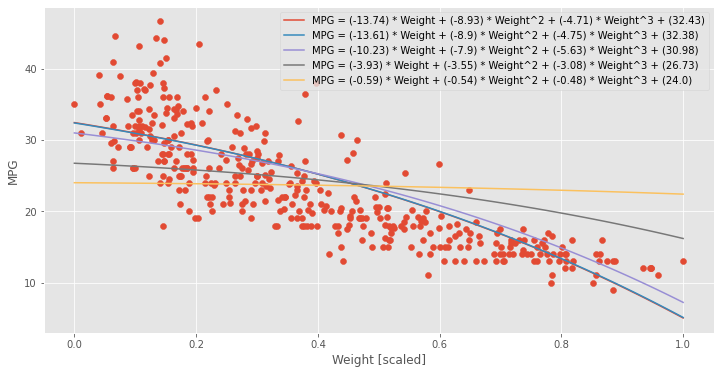

In [77]:
# Plot polynomial regression equation

# X-Y scatter plot with fitted line
x_min = min(X[:,1])
x_max = max(X[:,1])
x_plot = np.linspace(x_min, x_max, 100)

# Final fitted coefficients
theta_list = [theta_no_reg,theta_reg_03,theta_reg_10,theta_reg_100,theta_reg_1000]
eqn=[]
y_plot = []
for theta_final in theta_list:
    c = theta_final[0]
    m1 = theta_final[1]
    m2 = theta_final[2]
    m3 = theta_final[3]
    eqn.append('MPG = ({}) * Weight + ({}) * Weight^2 + ({}) * Weight^3 + ({})'.format(round(m1,2),
                                                                                       round(m2,2),
                                                                                       round(m3,2),
                                                                                       round(c,2)))
    y_plot.append(m1 * x_plot + m2 * (x_plot ** 2) + m3 * (x_plot ** 3) + c) 


plt.figure(figsize=(12,6))
plt.plot(x_plot,y_plot[0],label=eqn[0])
plt.plot(x_plot,y_plot[1],label=eqn[1])
plt.plot(x_plot,y_plot[2],label=eqn[2])
plt.plot(x_plot,y_plot[3],label=eqn[3])
plt.plot(x_plot,y_plot[4],label=eqn[4])
plt.scatter(X[:,1],y)
plt.legend()
plt.xlabel("Weight [scaled]")
plt.ylabel('MPG')
plt.show()



A higher resularization paramter pushes the linear model towards a intercept only model which has a high bias. Though not applicable in this example, regularization can be very effective in controlling overfitting.